Example 1: Load one file into the `Resonator` class
======================

**By: Faustin Carter, 2016**

This notebook imports the data from one Agilent file, creates a `Resonator` object, runs a fitting routine, and then plots the data and fit curves in a nice way.

Once you've understood this example, you should be able to replicate it with your own data simply be writing a custom `process_file` function and updating the code that finds the datafile.

In [1]:
#import all the necessary libraries

#For inline notebook figures
%matplotlib inline

#For high-res figures. You can comment this out if you don't have a retina screen
%config InlineBackend.figure_format = 'retina' 

import glob #For easy file grabbing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs #For plot arrangement
import pprint as pp #For pretty printing of dicts

Load up the `pyres` modules
----------
You'll need to change the path to reflect wherever you stored the code

In [2]:
import os

#Add the pyres folder to the path
import sys
sys.path.append(os.getcwd()+'pyres/')

#Load up the resonator code!
import pyres as pr

Load a file and process the data
----
This unpacks the file data into a dict objects. This block of code is the only thing you need to change to make this work with your data.

The data dict has the following quantities:

* **I, Q, and freq**: numpy arrays of data from the VNA file

* **name**: an arbitrary string describing the resonator. This is description of the physical object. So if you run two sweeps on the same resonator at different powers or temperatures, you should give them the same name.

* **pwr, temp**: floats that describe the power in dB and the temperature in K that the measurement was taken at.

In [3]:
#Load in a file
dataFile = './ExampleData/RES-1_-10_DBM_TEMP_0.113.S2P'

#Use the process_file routine to read the file and create a dict of resonator data
fileDataDict = pr.process_file(dataFile)

#Look at the contents of the dict:
pp.pprint(fileDataDict)

{'I': array([-0.022739, -0.022687, -0.02265 , ...,  0.063827,  0.063836,
        0.063869]),
 'Q': array([ 0.062457,  0.062449,  0.062447, ...,  0.02939 ,  0.029329,  0.02928 ]),
 'freq': array([  8.17088000e+09,   8.17088400e+09,   8.17088800e+09, ...,
         8.17887200e+09,   8.17887600e+09,   8.17888000e+09]),
 'name': 'RES-1',
 'pwr': -10.0,
 'temp': 0.113}


Make a `Resonator` object
-----------
You can either create a resonator object directly, or use the `makeResFromData` helper tool, which takes the data dict you made earlier as an argument. The `makeResFromData` tool also allows you to simultaneously fit the data to a model, by passing the model along.

`makeResFromData` returns a resonator object, as well as the temperature rounded to the nearest 5 mK and the power. This is for convenience when dealing with large numbers of `Resonator` objects programmatically.

The `Resonator` object takes the I, Q, and freq data and calculates magnitude and phase and tries to guess the baseline of the magnitude and the electrical delay (i.e. baseline) of the phase. It also sets up a `lmfit` `Parameters` object which can later be passed to a fitting function. The tool `lmfitRes` is a wrapper that applies a fit function to a `Resonator` object.

In [4]:
#Create a resonator object using the helper tool
resObj1 = pr.makeResFromData(fileDataDict)

#Create a resonator object using the helper tool and also fit the data
#To do this, we pass a function that initializes the parameters for the fit, and also the fit function
resObj2 = pr.makeResFromData(fileDataDict, paramsFn = pr.cmplxIQ_params, fitFn = pr.cmplxIQ_fit)

#Check the temperature and power
print 'Temperature = ', resObj1.temp
print 'Power = ', resObj1.pwr

#Check to see whether a results object exists
print 'Do fit results exist for the first object? ', resObj1.hasFit
print 'Do fit results exist for the second object? ', resObj2.hasFit


#Explicitly call the fitter on the first object.
#Here we will call it, and also override the guess for coupling Q with our own quess
resObj1.load_params(pr.cmplxIQ_params)
resObj1.do_lmfit(pr.cmplxIQ_fit, qc=5000)

#Check to see whether a results object exists again, now they are both True
print 'Do fit results exist for the first object? ', resObj1.hasFit
print 'Do fit results exist for the second object? ', resObj2.hasFit

#Compare the best guess for the resonant frequency (minimum of the curve) to the actual fit
print 'Guess = ', resObj2.fmin, ' Hz'
print 'Best fit = ', resObj2.lmfit_result.params['f0'].value, ' Hz'
print 'Best fit with different qc guess = ', resObj1.lmfit_result.params['f0'].value, ' Hz'

#You can see the fit is not terribly sensitive to the guess for qc.

Temperature =  0.113
Power =  -10.0
Do fit results exist for the first object?  False
Do fit results exist for the second object?  True
Do fit results exist for the first object?  True
Do fit results exist for the second object?  True
Guess =  8174865993.0  Hz
Best fit =  8174865637.69  Hz
Best fit with different qc guess =  8174865637.69  Hz


Make a pretty plot
---------
Fits aren't worth anything if you don't plot the results!!

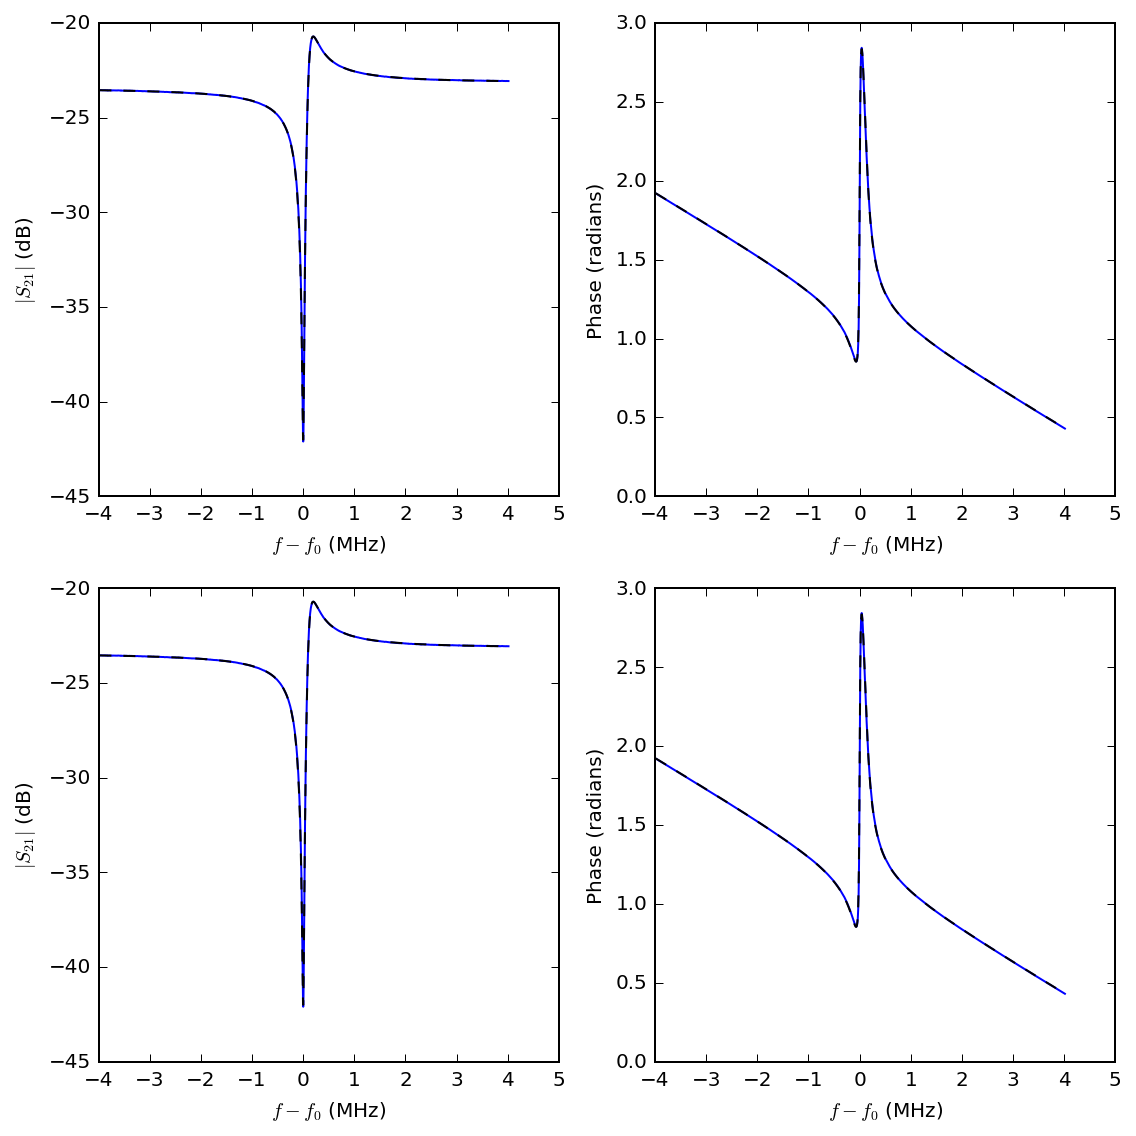

In [5]:
#Set up a figure to overlay the |S21| fit and data
figA = plt.figure()
figA.set_size_inches(8,8)

#Plot the first fit here
axMag1 = figA.add_subplot(221)
axPhase1 = figA.add_subplot(222)

#plot the second fit here
axMag2 = figA.add_subplot(223)
axPhase2 = figA.add_subplot(224)

#Here we will plot against f-f0
resf0 = resObj1.lmfit_result.params['f0'].value
axMag1.plot((resObj1.freq-resf0)*1e-6,20*np.log10(resObj1.mag))
axMag1.plot((resObj1.freq-resf0)*1e-6,20*np.log10(resObj1.resultMag), 'k--')

axPhase1.plot((resObj1.freq-resf0)*1e-6,resObj1.phase)
axPhase1.plot((resObj1.freq-resf0)*1e-6,resObj1.resultPhase, 'k--')

resf0 = resObj2.lmfit_result.params['f0'].value
axMag2.plot((resObj2.freq-resf0)*1e-6,20*np.log10(resObj2.mag))
axMag2.plot((resObj2.freq-resf0)*1e-6,20*np.log10(resObj2.resultMag), 'k--')

axPhase2.plot((resObj2.freq-resf0)*1e-6,resObj2.phase)
axPhase2.plot((resObj2.freq-resf0)*1e-6,resObj2.resultPhase, 'k--')

        
axMag1.set_xlabel('$f-f_0$ (MHz)')
axMag1.set_ylabel('$|S_{21}|$ (dB)')

axMag2.set_xlabel('$f-f_0$ (MHz)')
axMag2.set_ylabel('$|S_{21}|$ (dB)')

axPhase1.set_xlabel('$f-f_0$ (MHz)')
axPhase1.set_ylabel('Phase (radians)')

axPhase2.set_xlabel('$f-f_0$ (MHz)')
axPhase2.set_ylabel('Phase (radians)')

figA.tight_layout()

In [6]:
#Save that figure in the local directory. You worked hard for it!
figA.savefig('Mag-and-Phase-E1.png')

Find the maximum liklhood estimate of the fit params using ``emcee``
---
Let's use the built-in ``emcee`` hooks to compare the results of the ``lmfit`` values with the maximum liklihood values for the fit parameters.

In [7]:
#Call the emcee hook and pass it the fit function that calculates your residual.
#Since we already ran a fit, emcee will use that fit for its starting guesses.
resObj2.do_emcee(pr.cmplxIQ_fit)

In [8]:
#Check to see that a emcee result exists
print 'Does an emcee chain exist? ', resObj2.hasChain

#Look at the first few rows of the output chain:
chains = resObj2.emcee_result.flatchain

print '\nHead of chains:'
pp.pprint(chains.head())

#Grab the best-fit values from the parameters that were varied
lmfitvals = np.asarray([val.value for key, val in resObj2.lmfit_result.params.iteritems() if val.vary is True])
mlevals = np.asarray(resObj2.mle_vals)

#Compare withe the mle values (percent difference):
diffs = zip(resObj2.mle_labels, (mlevals - lmfitvals)*100/lmfitvals)

print '\nPerecent difference:'
pp.pprint(diffs)

Does an emcee chain exist?  True

Head of chains:
             df            f0            qc             qi     gain0  \
0  88550.040587  8.174826e+09  49352.255766  265989.027649  0.068201   
1  88550.040587  8.174826e+09  49352.255766  265989.027649  0.068201   
2  88550.040587  8.174826e+09  49352.255766  265989.027649  0.068201   
3  88550.040587  8.174826e+09  49352.255766  265989.027649  0.068201   
4  88554.310119  8.174827e+09  49354.111748  265990.723252  0.068200   

      gain1        gain2    pgain0       pgain1  
0  0.769829  1079.400354  4.317705 -1565.157377  
1  0.769829  1079.400354  4.317705 -1565.157377  
2  0.769829  1079.400354  4.317705 -1565.157377  
3  0.769829  1079.400354  4.317705 -1565.157377  
4  0.769844  1079.413308  4.317591 -1565.099120  

Perecent difference:
[('df', -0.00042724329011839269),
 ('f0', -5.3375190476140067e-07),
 ('qc', -0.0054657469198017604),
 ('qi', 0.0033279276645439286),
 ('gain0', 0.00044789747497524257),
 ('gain1', -0.007099829531

Make a sweet giant triangle confusogram of your ``emcee`` results.
---
If you don't have ``pygtc`` installed, open a terminal and type ``pip install pygtc``. Go ahead, I'll wait...

In [9]:
import pygtc

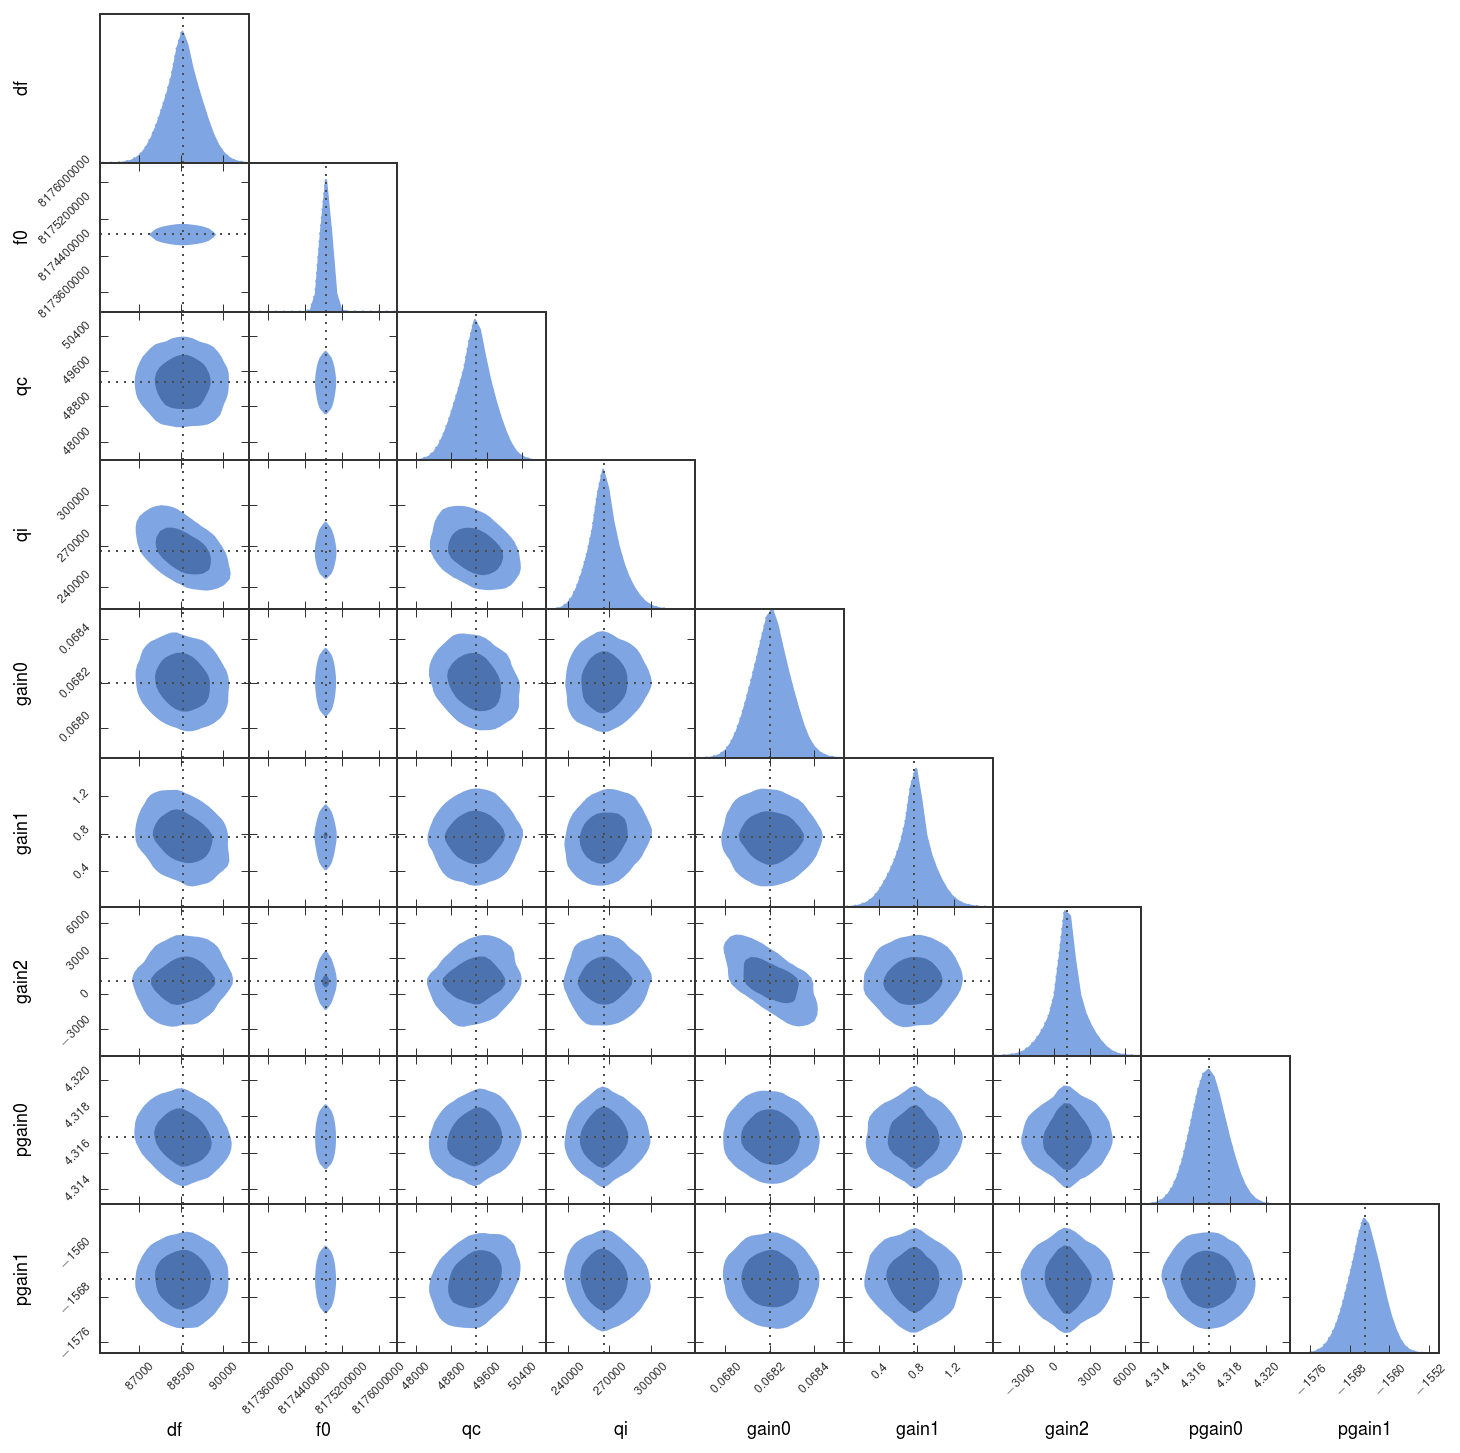

In [11]:
#Plot the triangle plot, and overlay the best fit values with dashed black lines (default)
figGTC = pygtc.plotGTC(chains, truths = lmfitvals, figureSize=12)